Data Source: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### Path of the data

In [2]:
data = "C:\\Users\\Kishore1\\Downloads\\Downloads_3rd_june_21\\archive\\cell_images"

### Number of Parasitized and uninfected images

In [3]:
for i in os.listdir(data):
    print("Number of {} images is {}".format(i,len(os.listdir(data+'\\'+i))))

Number of Parasitized images is 13779
Number of Uninfected images is 13779


### Visualizing some of the images

In [4]:
def sample_images(i,k):
    print(f" {i} cells")
    plt.figure(figsize=(15,3))
    for j in range(k):    
        plt.subplot(2,k,j+1)
        type_=i
        imgdir = data+'\\' +type_
        imgfile = np.random.choice(os.listdir(imgdir))
        img = imread(imgdir+"/"+imgfile)
        plt.imshow(img)
        plt.title(type_)
    plt.show() 

 Uninfected cells


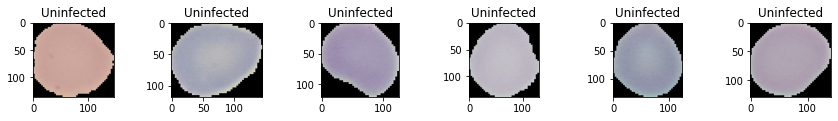

 Parasitized cells


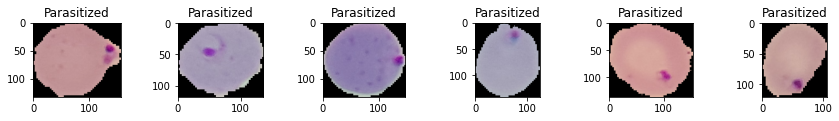

In [5]:
sample_images('Uninfected',6)
sample_images('Parasitized',6)

In [6]:
os.listdir(data)

['Parasitized', 'Uninfected']

### Plot of the image dimensions

1) Uninfected cells

In [7]:
dim1_uninfected = []
dim2_uninfected = []
for image_filename in os.listdir(data+'\\Uninfected'):
    img = imread(data+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1_uninfected.append(d1)
    dim2_uninfected.append(d2)

In [8]:
print(np.mean(dim1_uninfected))
print(np.mean(dim2_uninfected))

131.58001306335728
131.3424776834313


**Interpretation** : Mean Dimension of the uninfected cell is 131*131

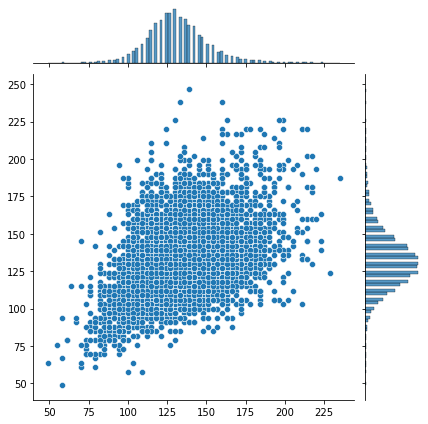

In [9]:
sns.jointplot(dim1_uninfected,dim2_uninfected)

2) Parasitized cells

In [10]:
dim1_Parasitized = []
dim2_Parasitized = []
for image_filename in os.listdir(data+'\\Parasitized'):
    img = imread(data+'\\Parasitized'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1_Parasitized.append(d1)
    dim2_Parasitized.append(d2)

In [11]:
print(np.mean(dim1_Parasitized))
print(np.mean(dim2_Parasitized))

134.3868930981929
133.6318310472458


**Interpretation** : Mean Dimension of the Parasitized cell is 134*133

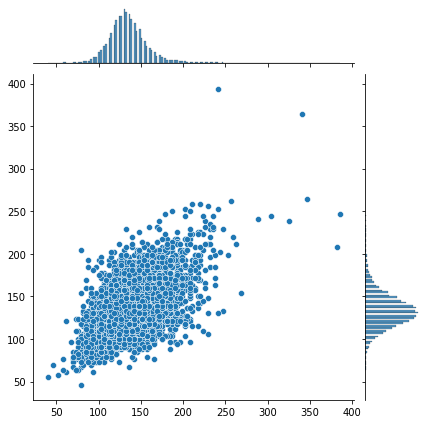

In [12]:
sns.jointplot(dim1_Parasitized,dim2_Parasitized)

### Image Generation

In [13]:
image_gen = ImageDataGenerator(rescale=1/255.0,
                               rotation_range=30,
                                width_shift_range=0.10,
                                height_shift_range=0.10,
                                horizontal_flip=True,
                                fill_mode='nearest',   
                               validation_split=0.2)           

In [14]:
image_shape = (131,131,3)

### Preparing train and test Image Generator

In [15]:
train_data=image_gen.flow_from_directory(data,subset="training",target_size=image_shape[:2],class_mode = 'binary',batch_size=16,shuffle=True)

val_data=image_gen.flow_from_directory(data,subset="validation",target_size=image_shape[:2],class_mode = 'binary',
                                                            batch_size=16,shuffle=True)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [16]:
5510/32

172.1875

In [17]:
len(val_data)

345

In [18]:
train_data[0][0].shape

(16, 131, 131, 3)

In [19]:
train_data[0][1]

array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

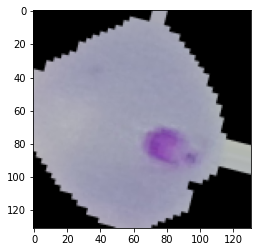

In [20]:
plt.imshow(train_data[5][0][5])

In [21]:
train_data[5][1][5]

0.0

In [22]:
train_data.class_indices

{'Parasitized': 0, 'Uninfected': 1}

### Model

In [23]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=image_shape))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 129, 129, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        1

### Early stop to avoid overfitting

In [25]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [26]:
len(train_data)

(16, 131, 131, 3)

In [ ]:
len(val_data)

### Fitting and training the model

In [27]:
results = model.fit(train_data,epochs=20,steps_per_epoch=len(train_data),validation_data=val_data,
                              validation_steps=len(val_data),
                              callbacks=[early_stop])

Epoch 1/20
1378/1378 [==============================] - 409s 296ms/step - loss: 0.4509 - accuracy: 0.7900 - val_loss: 0.2049 - val_accuracy: 0.9223
Epoch 2/20
1378/1378 [==============================] - 454s 330ms/step - loss: 0.2173 - accuracy: 0.9325 - val_loss: 0.1915 - val_accuracy: 0.9332
Epoch 3/20
1378/1378 [==============================] - 457s 332ms/step - loss: 0.1980 - accuracy: 0.9397 - val_loss: 0.2144 - val_accuracy: 0.9305
Epoch 4/20
1378/1378 [==============================] - 411s 298ms/step - loss: 0.1904 - accuracy: 0.9448 - val_loss: 0.1919 - val_accuracy: 0.9299
Epoch 5/20
1378/1378 [==============================] - 420s 305ms/step - loss: 0.1827 - accuracy: 0.9448 - val_loss: 0.1997 - val_accuracy: 0.9397


### Model Evaluation

In [37]:
model.evaluate_generator(val_data)

[0.20637033879756927, 0.9393829107284546]